# Import Libraries & Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from matplotlib.gridspec import GridSpec

# Read CSV File

In [3]:
PATH = 'delivery_data.csv'
df = pd.read_csv(PATH)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   45593 non-null  object 
 1   ID                           45593 non-null  object 
 2   Delivery_person_ID           45593 non-null  object 
 3   Delivery_person_Age          43739 non-null  float64
 4   Delivery_person_Ratings      43685 non-null  float64
 5   Restaurant_latitude          45593 non-null  float64
 6   Restaurant_longitude         45593 non-null  float64
 7   Delivery_location_latitude   45593 non-null  float64
 8   Delivery_location_longitude  45593 non-null  float64
 9   Order_Date                   45593 non-null  object 
 10  Time_Orderd                  43862 non-null  object 
 11  Time_Order_picked            45593 non-null  object 
 12  Weather conditions           44977 non-null  object 
 13  Road_traffic_den

# Fix Data Loading and Data Preprocessing

In [4]:
# Handle all missing values by dropping them
df = df.dropna()
df.isna().sum()

# No need to use the first three columns (note that the first column containing "One" counts as column zero)
df_clean = df.iloc[:, 3:]
df_clean.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30,11:45,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45,19:50,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,8:30,8:45,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,17:60,18:10,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30,13:45,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30.0


## Assumptions:
##### 1.⁠ From Time_Orderd_picked, we need to classify order time of the day
##### •⁠  ⁠convert hh:mm data format into minutes
##### •⁠  ⁠another data format is in decimal, 12 noon is 0.5 (so 24 hours in a day is made 0 to1 classification) so we need to classify into morning, afternoon, evening, night

##### 2.⁠ ⁠Delivery time = Time_Order_picked (min) – Time_Orderd (min) + Time_taken (min)
##### •⁠  ⁠However, 1731 data are missing from Time_Orderd (min)

In [5]:
df_clean["Time_Orderd"] = df_clean["Time_Orderd"].apply(lambda x: x.zfill(5) if isinstance(x, str) else x)
df_clean["DateTime_Order"] = pd.to_datetime(df_clean["Order_Date"] + " " + df_clean["Time_Orderd"], errors='coerce')

df_clean["Time_Order_picked"] = df_clean["Time_Order_picked"].apply(lambda x: x.zfill(5) if isinstance(x, str) else x)
df_clean["DateTime_Order_picked"] = pd.to_datetime(df_clean["Order_Date"] + " " + df_clean["Time_Order_picked"], errors='coerce')

df_clean = df_clean.dropna()

df_clean["Delivery_Time"] = ((df_clean["DateTime_Order_picked"] - df_clean["DateTime_Order"]).dt.total_seconds() / 60) + df_clean["Time_taken (min)"]
df_clean["Delivery_Time"].unique()

/var/folders/9x/8srq4tyd2nvbllff3s3bcdgh0000gn/T/ipykernel_2044/1452909789.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_clean["DateTime_Order"] = pd.to_datetime(df_clean["Order_Date"] + " " + df_clean["Time_Orderd"], errors='coerce')
/var/folders/9x/8srq4tyd2nvbllff3s3bcdgh0000gn/T/ipykernel_2044/1452909789.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_clean["DateTime_Order_picked"] = pd.to_datetime(df_clean["Order_Date"] + " " + df_clean["Time_Order_picked"], errors='coerce')


array([39., 38., 41., 45., 36., 55., 37., 44., 61., 33., 31., 30., 56.,
       48., 50., 35., 54., 23., 62., 22., 27., 40., 20., 21., 26., 57.,
       16., 28., 46., 64., 49., 29., 32., 24., 25., 42., 52., 34., 18.,
       59., 60., 43., 51., 58., 53., 68., 65., 47., 63., 17., 15., 66.,
       19., 67., 69.])

# Calculate Delivery Distance

In [6]:
df_clean["Manhattan_distance"] = (
    abs(df_clean["Delivery_location_latitude"] - df_clean["Restaurant_latitude"]) +
    abs(df_clean["Delivery_location_longitude"] - df_clean["Restaurant_longitude"])
)

In [7]:
def Haversine_Distance(lat1, lon1, lat2, lon2):
    R = 6731 #Radius of Earth in Kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2)) #convert degrees to radians

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c #distance in kilometers

# Apply Function to DataFrame

In [8]:
df_clean["Haversine_Distance_KM"] = df_clean.apply(
    lambda row: Haversine_Distance(row["Restaurant_latitude"], row["Restaurant_longitude"],
                             row["Delivery_location_latitude"], row["Delivery_location_longitude"]), axis=1
)

#Drop Order_Date, Time_orderd, Time_Order_picked, Restaurant_latitude, Restaurant_longitude, Delivery_location_latitude, Delivery_location_longitude
df_clean = df_clean.drop(["Order_Date", "Time_Orderd", "Time_Order_picked", "Restaurant_latitude", "Restaurant_longitude", 
            "Delivery_location_latitude", "Delivery_location_longitude"], axis=1)

df_clean.head()

,Delivery_person_Age,Delivery_person_Ratings,Weather conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),DateTime_Order,DateTime_Order_picked,Delivery_Time,Manhattan_distance,Haversine_Distance_KM
0,37.0,4.9,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24.0,2022-03-19 11:30:00,2022-03-19 11:45:00,39.0,0.04,3.196089
1,34.0,4.5,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33.0,2022-03-25 19:45:00,2022-03-25 19:50:00,38.0,0.26,21.324021
2,23.0,4.4,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26.0,2022-03-19 08:30:00,2022-03-19 08:45:00,41.0,0.02,1.640498
4,32.0,4.6,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30.0,2022-03-26 13:30:00,2022-03-26 13:45:00,45.0,0.08,6.561048
5,22.0,4.8,Cloudy,Jam,0,Buffet,motorcycle,1.0,No,Urban,26.0,2022-03-11 21:20:00,2022-03-11 21:30:00,36.0,0.06,4.870879


# Apply LabelEncoder to Convert Strings to Numbers

In [9]:
le = LabelEncoder() #Initialize the LabelEncoder
columns_to_encode = ["Weather conditions", "Road_traffic_density", "Type_of_order", "Type_of_vehicle", "Festival", "City"]

#Apply LabelEncoder to each specified column in the New DataFrame
for col in columns_to_encode:
    #if col in df_encoded.columns: #Ensure the column exists in the DataFrame
    df_clean[col+"_LE"] = le.fit_transform(df_clean[col])

df_clean = df_clean.drop(columns=["Weather conditions", "Road_traffic_density", "Type_of_order", "Type_of_vehicle", "Festival", "City"])
df_clean.head()

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,multiple_deliveries,Time_taken (min),DateTime_Order,DateTime_Order_picked,Delivery_Time,Manhattan_distance,Haversine_Distance_KM,Weather conditions_LE,Road_traffic_density_LE,Type_of_order_LE,Type_of_vehicle_LE,Festival_LE,City_LE
0,37.0,4.9,2,0.0,24.0,2022-03-19 11:30:00,2022-03-19 11:45:00,39.0,0.04,3.196089,4,0,3,1,0,2
1,34.0,4.5,2,1.0,33.0,2022-03-25 19:45:00,2022-03-25 19:50:00,38.0,0.26,21.324021,3,1,3,2,0,0
2,23.0,4.4,0,1.0,26.0,2022-03-19 08:30:00,2022-03-19 08:45:00,41.0,0.02,1.640498,2,2,1,1,0,2
4,32.0,4.6,1,1.0,30.0,2022-03-26 13:30:00,2022-03-26 13:45:00,45.0,0.08,6.561048,0,0,3,2,0,0
5,22.0,4.8,0,1.0,26.0,2022-03-11 21:20:00,2022-03-11 21:30:00,36.0,0.06,4.870879,0,1,0,1,0,2


# Splitting the Data

In [10]:
#Define features and target
X = df_clean.drop(columns=["Time_taken (min)", "DateTime_Order", "DateTime_Order_picked"])
y = df_clean["Time_taken (min)"]

#Split Data (80% train, 20% test)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

#Split Data from 20% Test
X_validation, X_test, y_validation, y_test = tts(X_test, y_test, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(26728, 13) (26728,) (3341, 13) (3341,) (3341, 13) (3341,)


# Incorporating Decision Tree Model
### Default Parameters 

In [11]:
# Initialize Model
dt_model = DecisionTreeRegressor(random_state=42)

# Train Model
dt_model.fit(X_train, y_train)
print('The Decision Tree Depth is: ', dt_model.get_depth())

# Predictions
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)
y_pred_dt_validation = dt_model.predict(X_validation)

print("Training data points:", X_train.shape[0])
print("Testing data points:", X_test.shape[0])
print("Validation data points:", X_validation.shape[0])

The Decision Tree Depth is:  27
Training data points: 26728
Testing data points: 3341
Validation data points: 3341


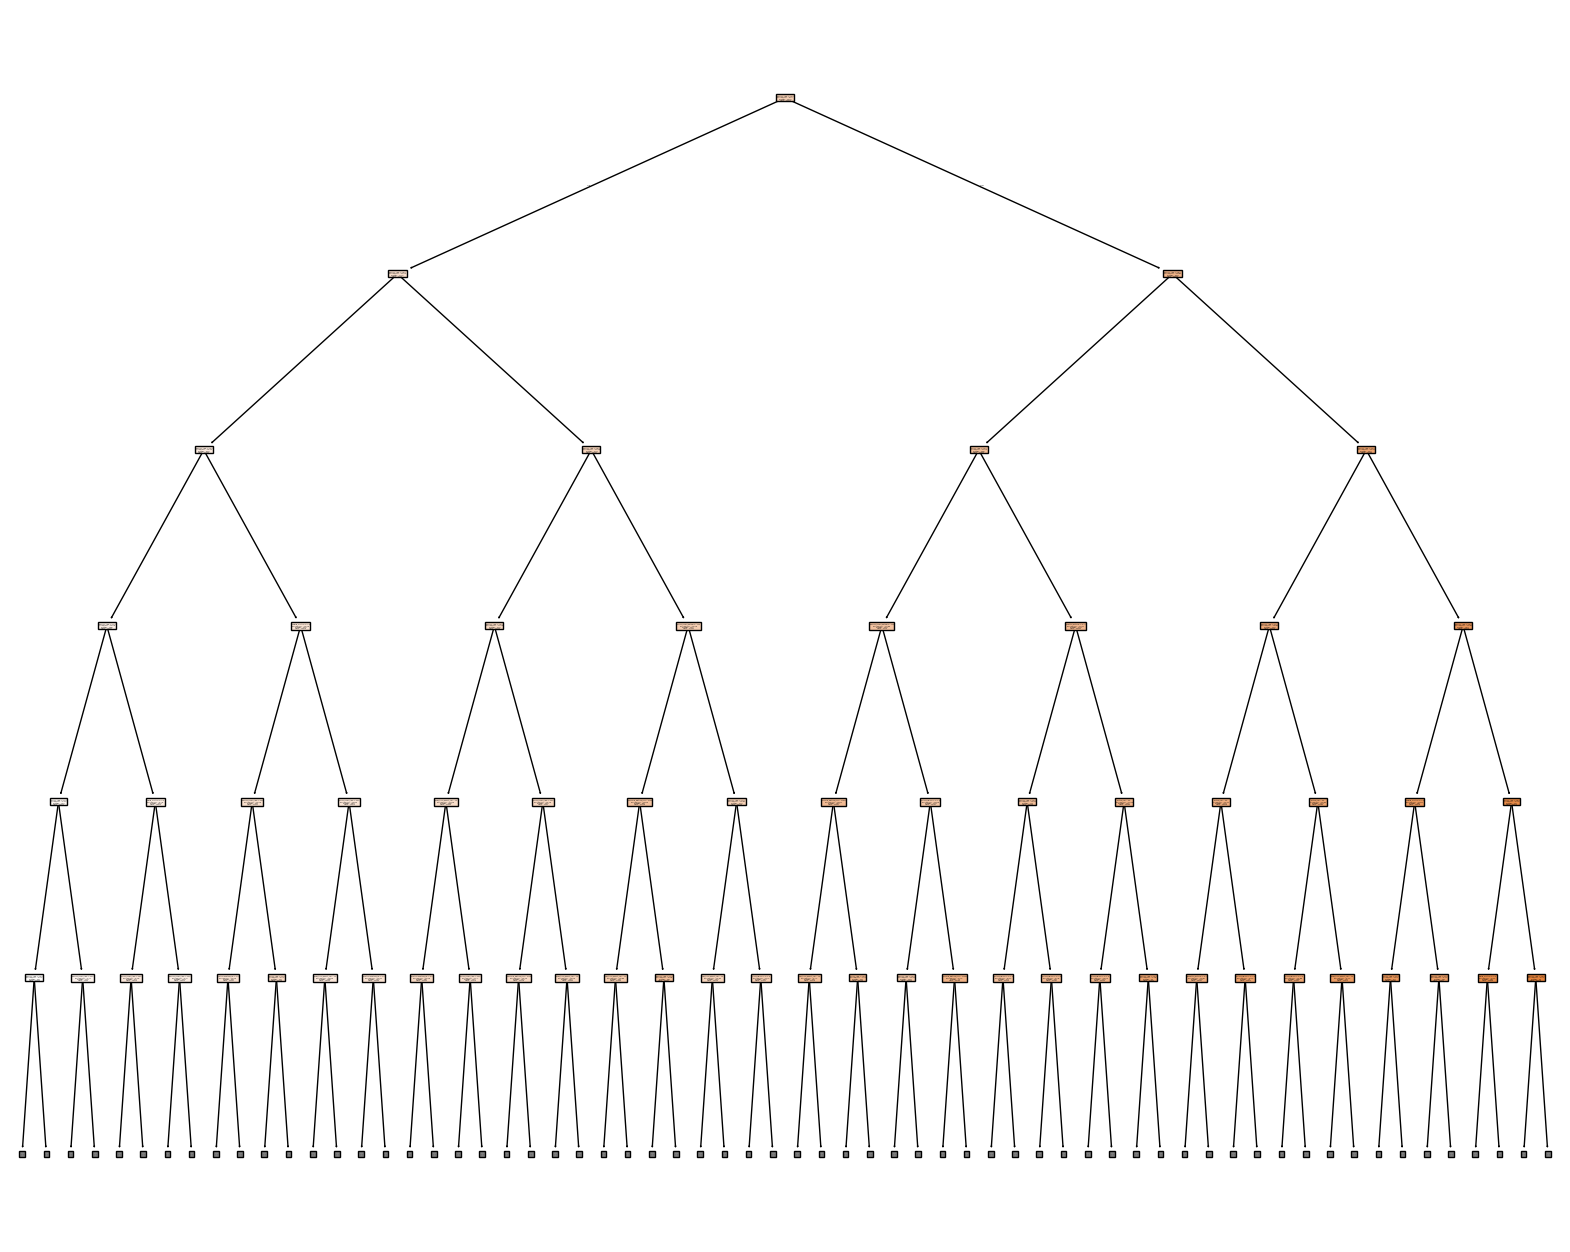

In [12]:
# Plot the decision tree, but only show the top 5 levels
plt.figure(figsize=(20, 16))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, max_depth=5)
plt.show()

# Evaluate the Decision Tree

In [13]:
dt_metrics = {
    "Decision Tree": {
        "MSE Test": mse(y_test, y_pred_dt_test),
        "MAE Test": mae(y_test, y_pred_dt_test),
        "EVS Test": evs(y_test, y_pred_dt_test),
        "MSE Validation": mse(y_validation, y_pred_dt_validation),
        "MAE Validation": mae(y_validation, y_pred_dt_validation),
        "EVS Validation": evs(y_validation, y_pred_dt_validation),
    },
} 

dt_metrics

{'Decision Tree': {'MSE Test': 13.04699191858725,
  'MAE Test': 2.2574079616881173,
  'EVS Test': 0.845020087245365,
  'MSE Validation': 13.473510924872793,
  'MAE Validation': 2.2936246632744686,
  'EVS Validation': 0.8462828311002422}}

# Tuning the Parameters for Decision Tree Model

In [14]:
dt_model_improve = DecisionTreeRegressor(max_depth=10)
dt_model_improve.fit(X_train, y_train)

print('The Decision Tree Depth is: ', dt_model_improve.get_depth())

# Predictions
y_pred_dt_train = dt_model_improve.predict(X_train)
y_pred_dt_test = dt_model_improve.predict(X_test)
y_pred_dt_validation = dt_model_improve.predict(X_validation)

The Decision Tree Depth is:  10


# Evaluate the Improved Decision Tree Model

In [15]:
dt_improve_metrics = {
    "Decision Tree": {
        "MSE Validation": mse(y_validation, y_pred_dt_validation),
        "MAE Validation": mae(y_validation, y_pred_dt_validation),
        "EVS Validation": evs(y_validation, y_pred_dt_validation),
    },
} 

dt_improve_metrics

{'Decision Tree': {'MSE Validation': 8.278911512988941,
  'MAE Validation': 2.2024684190127037,
  'EVS Validation': 0.9055474272922281}}

# Incorporating Random Forest Regressor Model
### Default Parameters

In [16]:
#Initialize Models
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
print(rf_model.get_params())

#Train Models
rf_model.fit(X_train, y_train)

#Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)
y_pred_rf_validation = rf_model.predict(X_validation)

print("Training data points:", X_train.shape[0])
print("Testing data points:", X_test.shape[0])
print("Validation data points:", X_validation.shape[0])

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Training data points: 26728
Testing data points: 3341
Validation data points: 3341


# Evaluate the Model

In [17]:
rf_metrics = {

"Random Forest": { "MSE Test": mse(y_test, y_pred_rf_test),
        "MAE Test": mae(y_test, y_pred_rf_test),
        "EVS Test": evs(y_test, y_pred_rf_test),
        "MSE Validation": mse(y_validation, y_pred_rf_validation),
        "MAE Validation": mae(y_validation, y_pred_rf_validation),
        "EVS Validation": evs(y_validation, y_pred_rf_validation),
    },
}

rf_metrics

{'Random Forest': {'MSE Test': 7.141554684226279,
  'MAE Test': 2.052283747381024,
  'EVS Test': 0.9151788655459585,
  'MSE Validation': 7.2464523795270885,
  'MAE Validation': 2.0735169111044596,
  'EVS Validation': 0.9173280516500198}}

# Tuning the Parameters for Random Forest Model

In [18]:
rf_model_improve = RandomForestRegressor(n_estimators=150)
rf_model_improve.fit(X_train, y_train)

print(rf_model_improve.get_params())

# Predictions
y_pred_rf_train = rf_model_improve.predict(X_train)
y_pred_rf_test = rf_model_improve.predict(X_test)
y_pred_rf_validation = rf_model_improve.predict(X_validation)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Evaluate the Improved Random Forest Model

In [19]:
rf_improve_metrics = {

"Random Forest": {"MSE Validation": mse(y_validation, y_pred_rf_validation),
        "MAE Validation": mae(y_validation, y_pred_rf_validation),
        "EVS Validation": evs(y_validation, y_pred_rf_validation),
    },
}

rf_improve_metrics

{'Random Forest': {'MSE Validation': 7.197455798330506,
  'MAE Validation': 2.0677002893345304,
  'EVS Validation': 0.9178907381056441}}

# Visualize Evaluation Metrics

Text(0.5, 1.0, 'Prediction vs Actual Values')

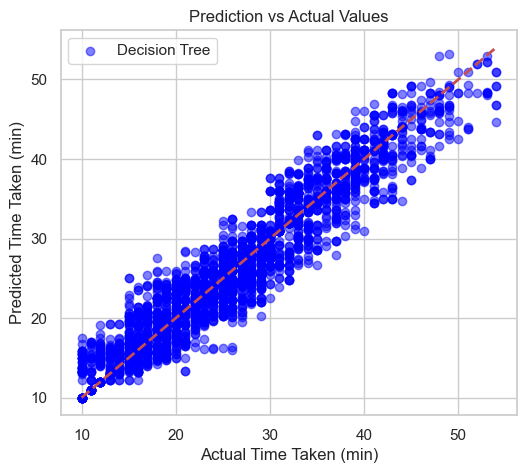

In [20]:
sns.set_theme(style="whitegrid")

# Figure 1: Prediction vs Actual Values
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_dt_test, label="Decision Tree", alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Identity Line
plt.xlabel("Actual Time Taken (min)")
plt.ylabel("Predicted Time Taken (min)")
plt.legend()
plt.title("Prediction vs Actual Values")

Text(0.5, 1.0, 'Prediction vs Actual Values')

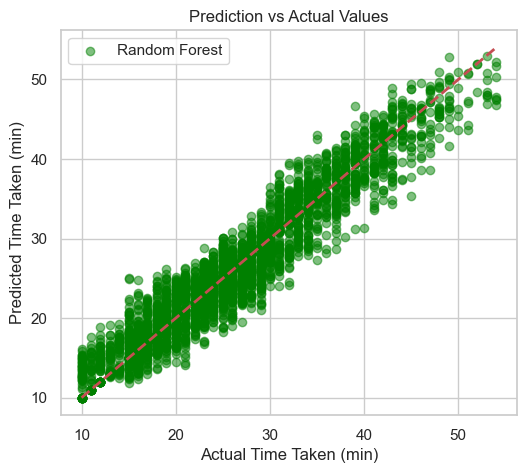

In [21]:
sns.set_theme(style="whitegrid")

#Figure 2: Prediction vs Actual Values
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf_test, label="Random Forest", alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Identity Line
plt.xlabel("Actual Time Taken (min)")
plt.ylabel("Predicted Time Taken (min)")
plt.legend()
plt.title("Prediction vs Actual Values")

In [22]:
# Using the provided metrics
dt_improve_metrics = {'Decision Tree': {'MSE Test': 8.201549535565663,
  'MAE Test': 2.177634097518919,
  'EVS Test': 0.9025853208420866,
  'MSE Validation': 8.274819359482468,
  'MAE Validation': 2.202589956483045,
  'EVS Validation': 0.9055943519750325}}

rf_improve_metrics = {'Random Forest': {'MSE Test': 7.119422714423492,
  'MAE Test': 2.0446932056270577,
  'EVS Test': 0.9154366527498446,
  'MSE Validation': 7.2246264524926,
  'MAE Validation': 2.06985533273471,
  'EVS Validation': 0.9175805446945436}}

In [23]:
# Extract the actual metrics dictionaries
dt_metrics = dt_improve_metrics['Decision Tree']
rf_metrics = rf_improve_metrics['Random Forest']

# Calculate improvement percentages
improvement_pct = {}
for metric in dt_metrics.keys():
    if 'EVS' in metric:
        # For EVS, higher is better
        improvement_pct[metric] = ((rf_metrics[metric] - dt_metrics[metric]) / dt_metrics[metric]) * 100
    else:
        # For MSE and MAE, lower is better
        improvement_pct[metric] = ((dt_metrics[metric] - rf_metrics[metric]) / dt_metrics[metric]) * 100

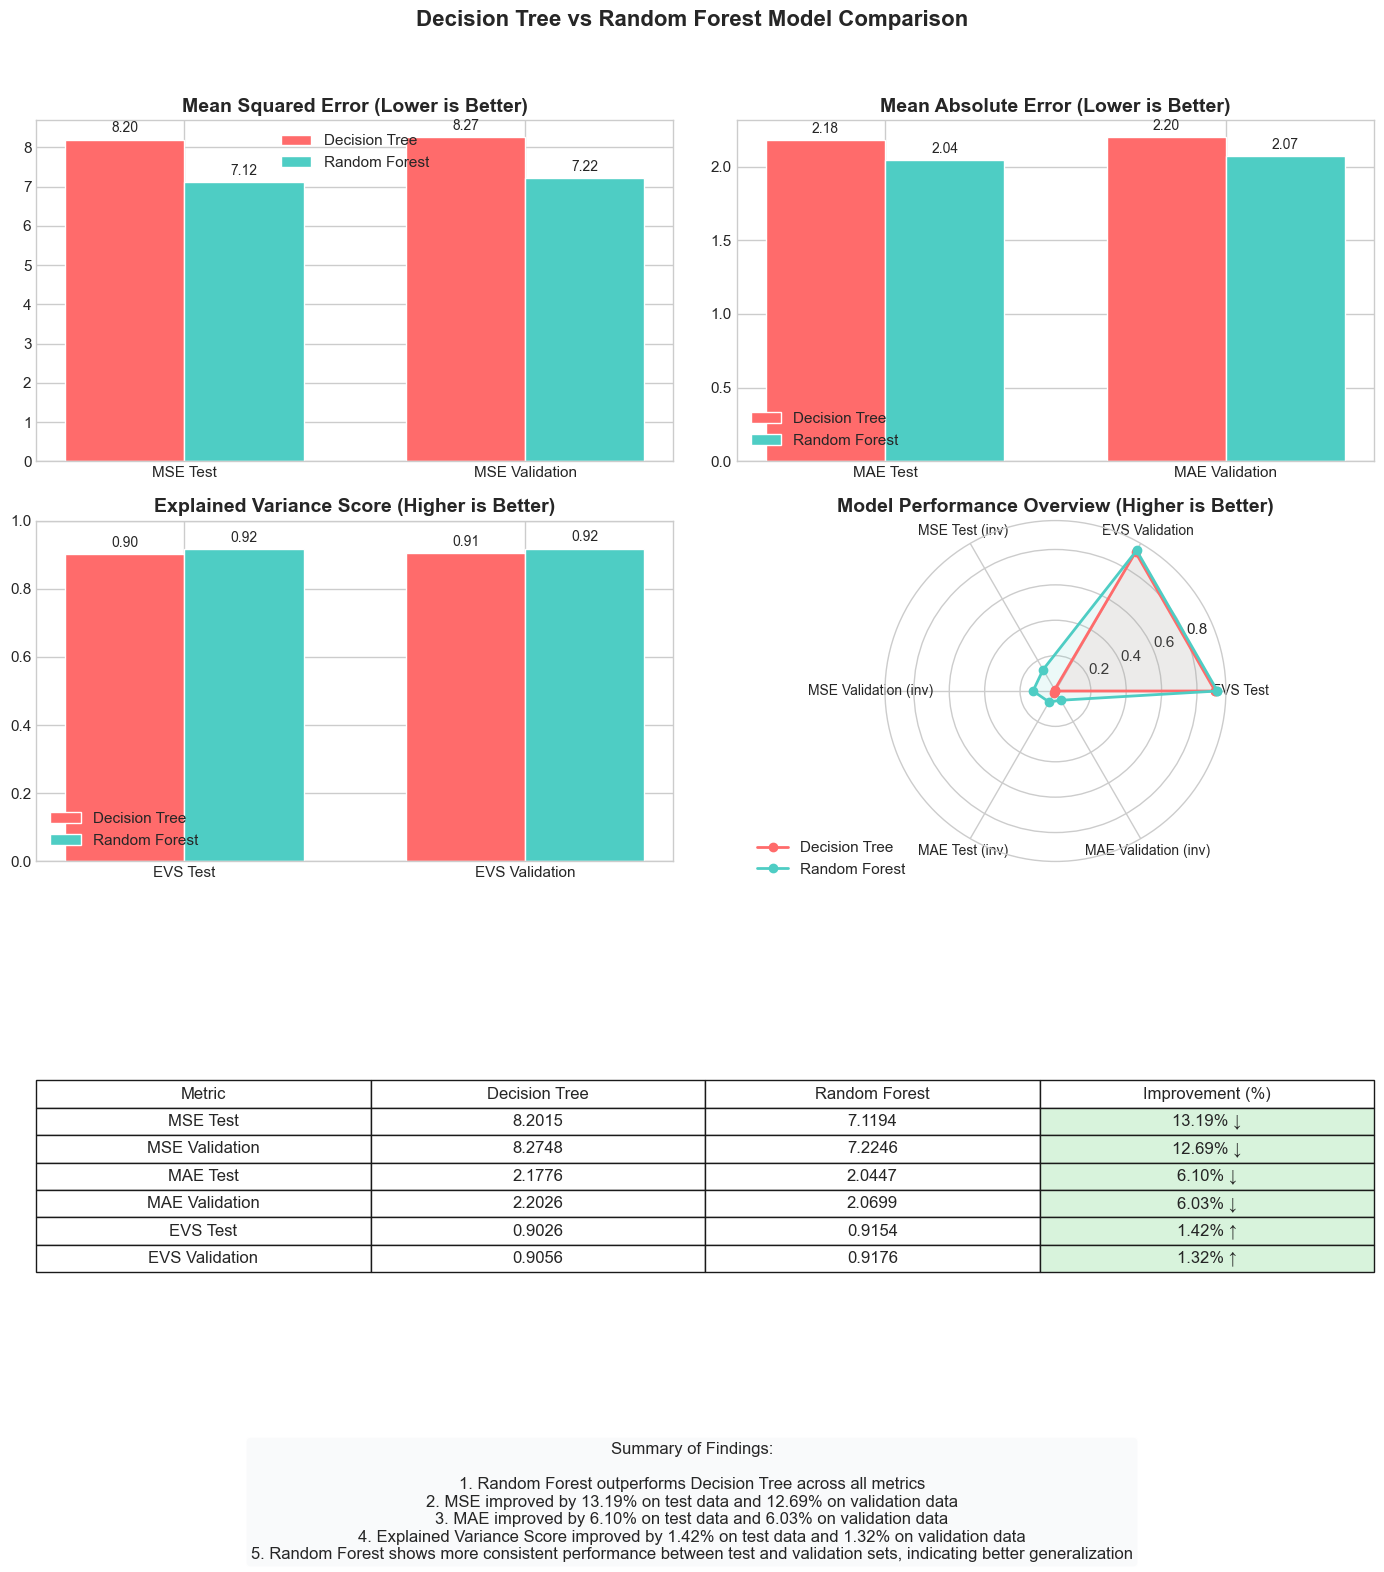

In [24]:
# Create a function to visualize the model comparison in the format shown in the example
def visualize_model_comparison(dt_metrics, rf_metrics, improvement_pct):
    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure with subplots in a grid
    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.5])
    
    # Define colors
    dt_color = '#FF6B6B'  # Red for Decision Tree
    rf_color = '#4ECDC4'  # Teal for Random Forest
    
    # 1. MSE Comparison (Test and Validation)
    ax1 = fig.add_subplot(gs[0, 0])
    metrics = ['MSE Test', 'MSE Validation']
    dt_values = [dt_metrics[m] for m in metrics]
    rf_values = [rf_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, dt_values, width, label='Decision Tree', color=dt_color)
    bars2 = ax1.bar(x + width/2, rf_values, width, label='Random Forest', color=rf_color)
    
    ax1.set_title('Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    
    # Add values on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    # 2. MAE Comparison (Test and Validation)
    ax2 = fig.add_subplot(gs[0, 1])
    metrics = ['MAE Test', 'MAE Validation']
    dt_values = [dt_metrics[m] for m in metrics]
    rf_values = [rf_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    
    bars1 = ax2.bar(x - width/2, dt_values, width, label='Decision Tree', color=dt_color)
    bars2 = ax2.bar(x + width/2, rf_values, width, label='Random Forest', color=rf_color)
    
    ax2.set_title('Mean Absolute Error (Lower is Better)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics)
    ax2.legend()
    
    # Add values on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    # 3. EVS Comparison (Test and Validation)
    ax3 = fig.add_subplot(gs[1, 0])
    metrics = ['EVS Test', 'EVS Validation']
    dt_values = [dt_metrics[m] for m in metrics]
    rf_values = [rf_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    
    bars1 = ax3.bar(x - width/2, dt_values, width, label='Decision Tree', color=dt_color)
    bars2 = ax3.bar(x + width/2, rf_values, width, label='Random Forest', color=rf_color)
    
    ax3.set_title('Explained Variance Score (Higher is Better)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics)
    ax3.set_ylim([0, 1])  # EVS is between 0 and 1
    ax3.legend()
    
    # Add values on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    # 4. Create a radar chart for overall comparison
    ax4 = fig.add_subplot(gs[1, 1], polar=True)
    
    # Categories for radar chart - we'll invert MSE and MAE so higher is always better
    categories = ['EVS Test', 'EVS Validation', 'MSE Test (inv)', 'MSE Validation (inv)', 'MAE Test (inv)', 'MAE Validation (inv)']
    
    # Normalize values for radar chart (max value for errors, as we're inverting them)
    max_mse = max(dt_metrics['MSE Test'], dt_metrics['MSE Validation'], rf_metrics['MSE Test'], rf_metrics['MSE Validation'])
    max_mae = max(dt_metrics['MAE Test'], dt_metrics['MAE Validation'], rf_metrics['MAE Test'], rf_metrics['MAE Validation'])
    
    # Create data arrays - normalize so higher values are always better
    dt_values = [
        dt_metrics['EVS Test'],
        dt_metrics['EVS Validation'],
        (max_mse - dt_metrics['MSE Test']) / max_mse,  # Invert MSE
        (max_mse - dt_metrics['MSE Validation']) / max_mse,  # Invert MSE
        (max_mae - dt_metrics['MAE Test']) / max_mae,  # Invert MAE
        (max_mae - dt_metrics['MAE Validation']) / max_mae,  # Invert MAE
    ]
    
    rf_values = [
        rf_metrics['EVS Test'],
        rf_metrics['EVS Validation'],
        (max_mse - rf_metrics['MSE Test']) / max_mse,  # Invert MSE
        (max_mse - rf_metrics['MSE Validation']) / max_mse,  # Invert MSE
        (max_mae - rf_metrics['MAE Test']) / max_mae,  # Invert MAE
        (max_mae - rf_metrics['MAE Validation']) / max_mae,  # Invert MAE
    ]
    
    # Need to duplicate first value to close the circular graph
    dt_values = np.append(dt_values, dt_values[0])
    rf_values = np.append(rf_values, rf_values[0])
    categories = np.append(categories, categories[0])
    
    # Set up the angle for each category
    angles = np.linspace(0, 2*np.pi, len(categories)-1, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Plot radar chart
    ax4.plot(angles, dt_values, 'o-', linewidth=2, label='Decision Tree', color=dt_color)
    ax4.fill(angles, dt_values, alpha=0.1, color=dt_color)
    ax4.plot(angles, rf_values, 'o-', linewidth=2, label='Random Forest', color=rf_color)
    ax4.fill(angles, rf_values, alpha=0.1, color=rf_color)
    
    # Set labels and title
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories[:-1], fontsize=10)
    ax4.set_title('Model Performance Overview (Higher is Better)', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # 5. Create a comparison table
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    # Prepare table data
    data = []
    metrics_list = ['MSE Test', 'MSE Validation', 'MAE Test', 'MAE Validation', 'EVS Test', 'EVS Validation']
    headers = ['Metric', 'Decision Tree', 'Random Forest', 'Improvement (%)']
    
    for metric in metrics_list:
        if 'EVS' in metric:
            better = "↑" if rf_metrics[metric] > dt_metrics[metric] else "↓"
        else:
            better = "↓" if rf_metrics[metric] < dt_metrics[metric] else "↑"
            
        data.append([
            metric, 
            f"{dt_metrics[metric]:.4f}", 
            f"{rf_metrics[metric]:.4f}", 
            f"{improvement_pct[metric]:.2f}% {better}"
        ])
    
    table = ax5.table(cellText=data, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    # Apply colors to the table based on improvement
    for i, metric in enumerate(metrics_list):
        if 'EVS' in metric:
            if rf_metrics[metric] > dt_metrics[metric]:
                table[(i+1, 3)].set_facecolor('#d8f3dc')  # Green for improvement
            else:
                table[(i+1, 3)].set_facecolor('#ffccd5')  # Red for decline
        else:
            if rf_metrics[metric] < dt_metrics[metric]:
                table[(i+1, 3)].set_facecolor('#d8f3dc')  # Green for improvement
            else:
                table[(i+1, 3)].set_facecolor('#ffccd5')  # Red for decline
    
    # Add a summary caption about findings
    avg_mse_improvement = (improvement_pct['MSE Test'] + improvement_pct['MSE Validation']) / 2
    avg_mae_improvement = (improvement_pct['MAE Test'] + improvement_pct['MAE Validation']) / 2
    avg_evs_improvement = (improvement_pct['EVS Test'] + improvement_pct['EVS Validation']) / 2
    
    summary_text = (
        "Summary of Findings:\n\n"
        f"1. Random Forest outperforms Decision Tree across all metrics\n"
        f"2. MSE improved by {improvement_pct['MSE Test']:.2f}% on test data and {improvement_pct['MSE Validation']:.2f}% on validation data\n"
        f"3. MAE improved by {improvement_pct['MAE Test']:.2f}% on test data and {improvement_pct['MAE Validation']:.2f}% on validation data\n"
        f"4. Explained Variance Score improved by {improvement_pct['EVS Test']:.2f}% on test data and {improvement_pct['EVS Validation']:.2f}% on validation data\n"
        "5. Random Forest shows more consistent performance between test and validation sets, indicating better generalization"
    )
    
    fig.text(0.5, 0.01, summary_text, ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.8), fontsize=12)
    
    plt.suptitle('Decision Tree vs Random Forest Model Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.96])
    
    return fig

# Generate the visualization that looks like the example
comparison_fig = visualize_model_comparison(dt_metrics, rf_metrics, improvement_pct)
comparison_fig.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

# Create DataFrame for further analysis if needed
def create_metrics_dataframe(dt_metrics, rf_metrics, improvement_pct):
    # Prepare data for DataFrame
    data = []
    for metric in dt_metrics.keys():
        if 'EVS' in metric:
            better = "↑" if rf_metrics[metric] > dt_metrics[metric] else "↓"
        else:
            better = "↓" if rf_metrics[metric] < dt_metrics[metric] else "↑"
            
        data.append({
            'Metric': metric,
            'Decision Tree': dt_metrics[metric],
            'Random Forest': rf_metrics[metric],
            'Improvement (%)': improvement_pct[metric],
            'Direction': better
        })
    
    df = pd.DataFrame(data)
    return df

# Create and save the metrics DataFrame
metrics_df = create_metrics_dataframe(dt_metrics, rf_metrics, improvement_pct)

# Show the plot
plt.show()